In [1]:
using DrWatson
@quickactivate "Attitude Control"

In [2]:
include("../src/dynamics.jl")
using Plots
using LinearAlgebra
using DifferentialEquations, DiffEqCallbacks
using SatelliteToolbox, ReferenceFrameRotations

In [3]:
function get_q_lvlh(r, v)
    r = r / norm(r)
    v = v / norm(v)
    
    x =  v           # Velocity vector
    y = -cross(r, v) # negative momentum vector
    z = -r           # Nadir vector
    
    A_lvlh = DCM([
        x y z
    ])
    
    # Handle q sign
    q = dcm_to_quat(A_lvlh)

    q
end

get_q_lvlh (generic function with 1 method)

In [4]:
function state_feedback(int)
    # Get parameters and states
    pars = SpacecraftModel.get_parameters(int)
    q, ω = SpacecraftModel.get_states(int)
    
    qₑ = inv(pars.qᵣ * q)
    ωₑ = ω - pars.ωᵣ
    
    e = [imag(qₑ); ωₑ]
    
    # State feedback
    K = 1e-3*[I(3) I(3)] 
    
    # Control output
    u = SpacecraftModel.set_ctrl_torque!(int, -K*e)
    
    # Add to internal momentum
    SpacecraftModel.set_internal_momentum!(int, 
        SpacecraftModel.get_internal_momentum(int) + u * pars.Δt
    )
end

state_feedback (generic function with 1 method)

In [5]:
function LVLH_reference(int)
    pars = SpacecraftModel.get_parameters(int)
    _, r, v = propagate!(pars.orbit, SpacecraftModel.get_time(int))
    
    q = get_q_lvlh(r, v)
    if(pars.qᵣ' * q < 0)
        q = -q
    end
    
    pars.qᵣ = q
end

LVLH_reference (generic function with 1 method)

In [6]:
tle_str = """
AAUSAT3
1 39087U 13009B   21104.06202311  .00000136  00000-0  61744-4 0  9999
2 39087  98.4313 308.7965 0013354 104.8269 255.4393 14.35917261425956
"""
tle = read_tle_from_string(tle_str)[1]

                             TLE
                            Name: AAUSAT3
                Satellite number: 39087
        International designator: 13009B  
                    Epoch (Year): 21
                     Epoch (Day): 104.06202311
              Epoch (Julian Day): 2459318.56202
              Element set number: 999
                    Eccentricity:   0.00133540 deg
                     Inclination:  98.43130000 deg
                            RAAN: 308.79650000 deg
             Argument of perigee: 104.82690000 deg
                    Mean anomaly: 255.43930000 deg
                 Mean motion (n):  14.35917261 revs/day
               Revolution number: 42595

                              B*: 0.000062 1/[er]

                        1   d
                       ---.--- n: 0.000001 rev/day²
                        2  dt

                        1   d²
                       ---.--- n: 0.000000 rev/day³
                        6  dt²

In [7]:
q₀ = randn(4); q₀ = q₀ / norm(q₀);
ω₀ = randn(3); ω₀ = ω₀ / norm(ω₀) * deg2rad(3);
qᵣ = [1; 0; 0; 0]; qᵣ = Quaternion(qᵣ / norm(qᵣ))
ωᵣ = [0; 0; 0]
J = [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.4]

orbit = init_orbit_propagator(Val(:J4), tle)

pars = SpacecraftModel.Parameters(J=J, qᵣ=qᵣ, ωᵣ=ωᵣ, orbit=orbit)

callbacks = CallbackSet(
    PeriodicCallback(LVLH_reference, 1),
    PeriodicCallback(state_feedback, 1),
)

t_orb = 24*60*60 / tle.n
sim_n = 2
sim_t = sim_n*t_orb
x₀ = [q₀; ω₀]
sol = SpacecraftModel.run_simulation(x₀, pars, sim_t, callbacks);

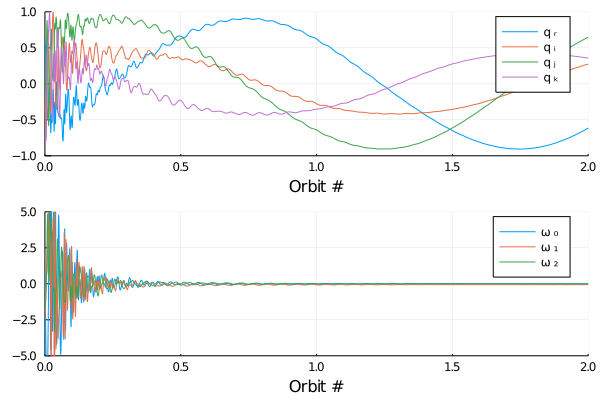

In [8]:
q_plot = plot(sol.t / t_orb, sol[1:4, :]', 
    xlabel="Orbit #",
    xlims=(0, sol.t[end] / t_orb),
    ylims=(-1,1),
    label=["q ᵣ" "q ᵢ" "q ⱼ" "q ₖ"]
)

ω_plot = plot(sol.t / t_orb, rad2deg.(sol[5:7, :]'), 
    xlabel="Orbit #",
    xlims=(0, sol.t[end] / t_orb),
    ylims=(-5,5),
    label=["ω ₀" "ω ₁" "ω ₂"]
)

plot(q_plot, ω_plot,
    layout=@layout[a ; b]
)

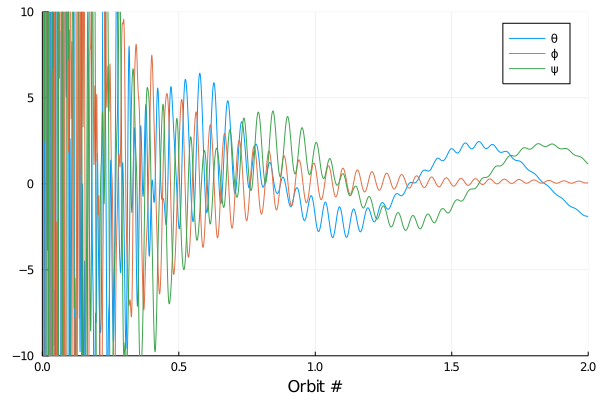

In [9]:
# Performance calculations
_, r, v = propagate!(orbit, 0:sim_t);
q_lvlh = map((r, v) -> get_q_lvlh(r, v), r, v)
q = map(t -> Quaternion(sol(t)[1:4]), 0:sim_t)
qₑ = map((qᵣ, q) -> qᵣ * q, q_lvlh, q)

ang = map(rot -> [rot.a1, rot.a2, rot.a3],
    map(q -> quat_to_angle(q, :XYZ), qₑ)
)
θ = map(a -> rad2deg(a[1]), ang)
ϕ = map(a -> rad2deg(a[2]), ang)
ψ = map(a -> rad2deg(a[3]), ang)

plot(0:1/t_orb:sim_n, [θ ϕ ψ],
    label=["θ" "ϕ" "ψ"],
    xlabel="Orbit #",
    xlims=(0, sol.t[end] / t_orb),
    ylims=(-10,10),
)